# K-Clustering using Reinforcement Learning

## DM-Gym prototype testing

### By Ashwin Devanga

#### Import Base Packages

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt

#### import datamining gym packages

In [2]:
from dm_gym.utils.data_gen import data_gen_clustering
from dm_gym.create_env import ray_create_env

#### import ray packages for prebuilt RL models

In [3]:
%%capture
import ray
from ray.rllib import agents
from ray import tune

#### Function to register environment with ray[tune]

In [4]:
def register_env(env_name, env_config={}):
    env = ray_create_env(env_name)
    tune.register_env(env_name, 
        lambda env_name: env(env_name,
            env_config=env_config))

#### Sample Data Generation (Simulated data)

In [5]:
n = 2 ###Number of dimentions in the data
k = 3 ###Number of clusters we want in the data

num_records = 100
parameter_means = []
parameter_sd = []

In [6]:
data_gen = data_gen_clustering()

error, error_code, pm, psd = data_gen.param_init(n=n, k=k, num_records=num_records,
                                                 parameter_means=parameter_means, parameter_sd=parameter_sd)
data = data_gen.gen_data()
data

,1,2
0,-1.069397,-0.472053
1,0.239141,0.794583
2,-0.463424,1.761202
3,-1.387132,-0.274728
4,2.149660,2.469726
...,...,...
94,5.935539,4.303854
95,6.796786,3.544443
96,7.220128,3.910534
97,7.122993,3.467174


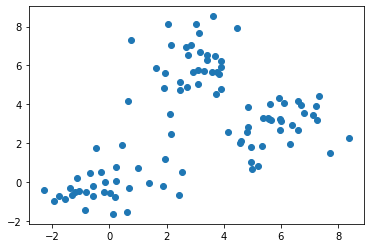

In [7]:
### Plot the data
plt.scatter(data[1], data[2])
plt.savefig("data_plotted.svg", dpi=300)
plt.show()

#### Run Mean-Shift model on the data

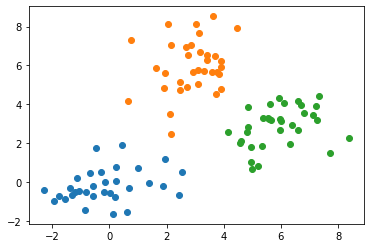

In [8]:
final_df, coords = data_gen.gen_model(data)
for cls in final_df['Class'].unique():
    plt.scatter(final_df[final_df['Class'] == cls][1], final_df[final_df['Class'] == cls][2])
plt.savefig("expected_output.svg", dpi=300)
plt.show()

#### Model and environment configurations

In [9]:
env_name = "clustering-v4"

env_config = {
    'data': data,
    'k': k,
}

epochs = 1000

rl_config = dict(
    log_level = "ERROR",
    env=env_name,
    
    num_workers=10,
    num_gpus=1,
    
    env_config=env_config,
    
    double_q=True,
    model=dict(
        vf_share_layers=False,
        fcnet_activation='relu',
        fcnet_hiddens=[128, 64]
    ),
    exploration_config={
        "type": "EpsilonGreedy",
        "initial_epsilon": 1.0,
        "final_epsilon": 0.02,
        "epsilon_timesteps": 0.9*epochs,
    },
    evaluation_config={
        "explore": False,
    },
    gamma = 1,
    target_network_update_freq=500,
    buffer_size=100,
    adam_epsilon=1e-8,
    grad_clip=40,
    train_batch_size=32,
    framework='torch',
    lr=1e-5
)

#### Train the model 

In [10]:
# Register environment
ray.shutdown()
register_env(env_name, env_config)

# Initialize Ray and Build Agent
info = ray.init(num_cpus=10, ignore_reinit_error=True, log_to_driver=False)
print("Dashboard URL: http://{}".format(info["webui_url"]))

agent = agents.dqn.DQNTrainer(env=env_name,
    config=rl_config)
results = []

rew = np.nan

pbar = tqdm(range(epochs), desc='Training Loop' )

for i in pbar:
    res = agent.train()
    results.append(res)
    rew = res['episode_reward_mean']
    pbar.set_description("reward = %f" % rew)
ray.shutdown()

2021-10-12 09:41:34,246	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


Dashboard URL: http://127.0.0.1:8265


2021-10-12 09:41:55,072	INFO trainable.py:106 -- Trainable.setup took 10.971 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
reward = -34.817487: 100%|██████████| 1000/1000 [38:44<00:00,  2.32s/it]


#### Plot Rewards

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
# Unpack values from each iteration
rewards = np.hstack([i['episode_reward_mean'] 
    for i in results])

p = 50

mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                if i >= p else np.mean(rewards[:i+1]) 
                for i, _ in enumerate(rewards)])
std_rewards = np.array([np.std(rewards[i-p:i+1])
               if i >= p else np.std(rewards[:i+1])
               for i, _ in enumerate(rewards)])

#plt.figure(constrained_layout=True, figsize=(16, 9))
plt.fill_between(np.arange(len(mean_rewards)), 
                 mean_rewards - std_rewards, 
                 mean_rewards + std_rewards, 
                 label='Standard Deviation', alpha=0.3)
plt.plot(mean_rewards, label='Mean Rewards')
plt.ylabel('Rewards')
plt.xlabel('Episode')
plt.title('Training Rewards')
plt.legend()
plt.savefig("Results_Rewards.svg", dpi=300)
plt.show()

Figure(432x288)


#### Plot Loss (td error)

In [12]:
td_err = [
    i['info']['learner']['default_policy']['mean_td_error'] 
    for i in results]


p = 50

mean_td_err = np.array([np.mean(td_err[i-p:i+1]) 
                if i >= p else np.mean(td_err[:i+1]) 
                for i, _ in enumerate(td_err)])
std_td_err = np.array([np.std(td_err[i-p:i+1])
               if i >= p else np.std(td_err[:i+1])
               for i, _ in enumerate(td_err)])

#plt.figure(constrained_layout=True, figsize=(16, 9))
plt.fill_between(np.arange(len(mean_td_err)), 
                 mean_td_err - std_td_err, 
                 mean_td_err + std_td_err, 
                 label='Standard Deviation', alpha=0.3)
plt.plot(mean_td_err, label='Mean td_err')
plt.ylabel('td_err')
plt.xlabel('Episode')
plt.title('Training td_err')
plt.legend()
plt.savefig("Results_TD_err.svg", dpi=300)
plt.show()

Figure(432x288)


#### Run through the environment with the agent to get final output

In [13]:
from dm_gym.create_env import create_env

env = create_env(env_name, env_config=env_config)

episode_reward = 0
done = False
obs = env.reset()
while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)

In [14]:
### Plot final output
final_df = info['final_state_data']
for cls in final_df['action'].unique():
    plt.scatter(final_df[final_df['action'] == cls][1], final_df[final_df['action'] == cls][2])
plt.savefig("rl_predicted_output.svg", dpi=300)
plt.show()

Figure(432x288)
